In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import networkx as nx
import sys
import random
sys.path.append('../src/')
from random_graph import RandGraph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Lambda, multiply
from keras.initializers import RandomUniform

Using TensorFlow backend.


## Model

Adrien Lucas Ecoffet suggested in his [post](https://becominghuman.ai/lets-build-an-atari-ai-part-1-dqn-df57e8ff3b26) to use a second input as a mask of possible actions. This mask will be multiplied by the output of all possible actions. This filtered output is the Q value. Thus the network compute the Q values for all possible actions but the gradient will be updated according to the loss of the specific action chosen.

In [4]:
nb_values = 6
nb_actions = 6

In [5]:
values_input = Input((nb_values,), name='values')
action_input = Input((nb_actions,), name='mask')

In [6]:
x = Dense(32, activation='relu')(values_input)
x = Dense(32, activation='relu')(x)
output = Dense(nb_actions)(x)
filtered_output = multiply([output, action_input])

model = Model(inputs=[values_input, action_input], outputs=filtered_output)


In [7]:
model.compile(optimizer='rmsprop', loss='mse')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
values (InputLayer)             (None, 6)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           224         values[0][0]                     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           1056        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 6)            198         dense_2[0][0]                    
__________________________________________________________________________________________________
mask (Inpu

In [455]:
def create_model(nb_values, nb_actions):
    values_input = Input((nb_values,), name='values')
    action_input = Input((nb_actions,), name='mask')
    x = Dense(32, activation='relu')(values_input)
    x = Dense(32, activation='relu')(x)
    output = Dense(nb_actions)(x)
    filtered_output = multiply([output, action_input])
    model = Model(inputs=[values_input, action_input], outputs=filtered_output)
    model.compile(optimizer='rmsprop', loss='mse')
    return model

In [456]:
model = create_model(nb_values, nb_actions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
values (InputLayer)             (None, 6)            0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32)           224         values[0][0]                     
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 32)           1056        dense_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 6)            198         dense_5[0][0]                    
__________________________________________________________________________________________________
mask (Inpu

## Fit batch

In [8]:
gamma = 0.99
start_states = np.array([[0.1,0,0,0,0,0]]) # loading of the 6 core nodes
actions = np.array([[0,1,0,1,0,0]]) # one hot encoding of blocked nodes
rewards = np.array([[0.0]])
next_states = np.array([[0.2,0.1,0,0,0,0]]) # next values after action

In [9]:
# get all the Q_values for this specific states
next_Q_values = model.predict([next_states, np.ones_like(actions)])

In [10]:
next_Q_values

array([[-0.00798716,  0.0077505 , -0.08062326,  0.10341002, -0.01462328,
         0.05416442]], dtype=float32)

In [11]:
# bellman
Q_values = rewards + gamma * np.max(next_Q_values, axis=1)

In [12]:
Q_values

array([[0.10237592]])

In [14]:
0.99 * 0.10341002

0.1023759198

In [15]:
# target Q_values
out = actions * Q_values

In [16]:
out

array([[0.        , 0.10237592, 0.        , 0.10237592, 0.        ,
        0.        ]])

In [17]:
# train
model.fit([start_states, actions], out, batch_size=len(start_states))

Epoch 1/1
1/1 [==============================] - 0s 61ms/step - loss: 0.0027


In [18]:
# check the Q values after update
model.predict([next_states, np.ones_like(actions)])

array([[-0.01481351,  0.03179383, -0.07861096,  0.11500031, -0.02085284,
         0.05248125]], dtype=float32)

In [625]:
def fit_batch(model, start_states, actions, rewards, next_states, gamma):
    # get all the Q_values for this specific states
    next_Q_values = model.predict([next_states, np.ones_like(actions)])
    # bellman
    Q_values = rewards + gamma * np.max(next_Q_values, axis=1)[:,None]
    # target Q_values
    out = actions * Q_values 
    # train
    model.fit([start_states, actions], out, batch_size=len(start_states), verbose=0)

## Memory

In [463]:
class Memory():
    def __init__(self, shape):
        self.m = self._memory(shape)
        
    def _memory(self, shape):
        m = 0.25 * np.random.randn(*shape) + 0.5 # * tuple unpacking
        m[0] = np.nan
        return m

    def remember(self, val):
        end_pos = np.where(np.isnan(self.m))[0][0]
        self.m[end_pos,:] = val
        if end_pos == self.m.shape[0]-1:
            end_pos = 0
        else:
            end_pos += 1
        self.m[end_pos,:] = np.nan
        

    def batch(self, size):
        s = tuple(np.subtract(self.m.shape , [1]+[0] * (len(self.m.shape)-1)))
        spl = np.random.choice(np.arange(x), size=size)
        return self.m[np.where(~ np.isnan(self.m))].reshape(s)[spl]

In [464]:
m = Memory((64,6))

In [468]:
m.batch(8)

array([[1.11709942, 0.35347347, 0.61842722, 0.65376869, 0.50429132,
        0.62566185],
       [0.67102594, 0.13605903, 0.80715872, 0.53832302, 0.88781922,
        0.25599433],
       [0.67102594, 0.13605903, 0.80715872, 0.53832302, 0.88781922,
        0.25599433],
       [0.33400271, 0.74263135, 0.27407966, 0.12802172, 0.25432643,
        0.35560663],
       [0.32096768, 0.60300088, 0.60503297, 0.50593094, 0.47200723,
        0.62622362],
       [0.32096768, 0.60300088, 0.60503297, 0.50593094, 0.47200723,
        0.62622362],
       [0.67102594, 0.13605903, 0.80715872, 0.53832302, 0.88781922,
        0.25599433],
       [0.44895526, 0.7247081 , 0.30396462, 0.70213947, 0.74230295,
        0.24496137]])

In [465]:
model = create_model(6,6)

In [473]:
fit_batch(model, m.batch(1), np.array([[0,0,0,0,1,0]]), np.array([0,0,0,0,1,0]), np.array([[0,0,0,0,0,0]]), gamma)

## graph

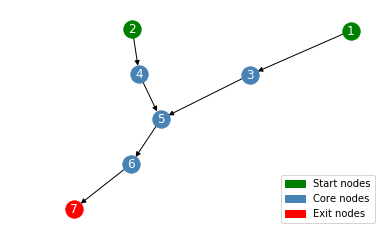

In [474]:
g = RandGraph(actors=1000, graph_type='simple')
g.plot()

## Action space

In [479]:
from itertools import combinations

In [477]:
g.core_nodes

[3, 4, 5, 6]

In [480]:
comb = []
for i in range(1,len(g.core_nodes)+1):
    comb.extend(list(combinations(g.core_nodes,i)))
    

In [667]:
comb

[(3,),
 (4,),
 (5,),
 (6,),
 (3, 4),
 (3, 5),
 (3, 6),
 (4, 5),
 (4, 6),
 (5, 6),
 (3, 4, 5),
 (3, 4, 6),
 (3, 5, 6),
 (4, 5, 6),
 (3, 4, 5, 6)]

In [669]:
comb.index((3,4))

4

## one_hot array for action space

In [512]:
action_space = np.zeros((len(comb), len(g.core_nodes)))

In [513]:
action_space.shape

(15, 4)

In [514]:
for i,line in enumerate(comb):
    for n in line:
        col = n - min(g.core_nodes)
        action_space[i,col] = 1

In [515]:
action_space

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 1., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 0., 1.],
       [0., 1., 1., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 1.],
       [1., 1., 1., 0.],
       [1., 1., 0., 1.],
       [1., 0., 1., 1.],
       [0., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [516]:
action_space[np.random.randint(len(action_space), size=2)]

array([[0., 1., 0., 1.],
       [1., 1., 0., 0.]])

In [525]:
list(np.where(action_space[:2] == 1.)[1] + min(g.core_nodes))

[3, 4]

In [677]:
comb[random.randint(0,len(comb))]

(3, 6)

In [672]:
a = np.zeros((1,len(comb)))

In [673]:
a[:,comb.index((3,4))] = 1

In [674]:
a

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [681]:
comb[np.where(a == 1.)[1][0]]

(3, 4)

In [745]:
class Action_space():
    def __init__(self, g):
        self.nodes = g.core_nodes
        self.comb = self.action_combinations()
#         self.action_space = self.act_space()
        
    def action_combinations(self):
        comb = []
        for i in range(1,len(self.nodes)+1):
            comb.extend(list(combinations(self.nodes,i)))
        return comb
    
#     def act_space(self):
#         action_space = np.zeros((len(self.comb) + 1, len(self.nodes)))
#         for i,line in enumerate(self.comb):
#             for n in line:
#                 col = n - min(self.nodes)
#                 action_space[i,col] = 1
#         return action_space
    
    def sample(self):
        a = np.zeros((1,len(self.comb)))
        idx = self.comb[random.randint(0,len(self.comb)-1)]
        a[:,self.comb.index(idx)] = 1
        return a
    
    def get_nodes(self, action):
        idx = np.where(action == 1.)[1][0]
        return comb[idx]

In [746]:
action_space = Action_space(g)

In [747]:
action_space.sample()

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [693]:
action_space.get_nodes(np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]))

(3, 4, 5)

In [694]:
np.argmax(np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]))

10

## $\epsilon$-greedy schedule

In [652]:
0.99 - 0.001*900

0.08999999999999997

In [658]:
def get_epsilon_for(iteration):
    e = 0.99 - 0.0001*iteration
    if e < 0.1:
        e = 0.1
    return e

## Training

In [ ]:
g = RandGraph(actors=20000, graph_type='simple')
# epsilon = 0.9
total_reward = []
i = len(g.core_nodes)

state, reward = g.action()
# action space
action_space = Action_space(g)
# store state, action, next_state, reward
memory = Memory((5000, len(g.core_nodes)*2 + len(action_space.comb) + 1))

action = action_space.sample()

model = create_model(state.shape[-1] , action.shape[-1] )


for t_time in range(20000):
    #which action
    epsilon = get_epsilon_for(t_time)
    if np.random.randn() < epsilon:
        action = action_space.sample()
    else:
        q_values = model.predict([state, np.ones_like(action)])
        idx = np.argmax(q_values)
        action = np.zeros((1, len(action_space.comb)))
        action[:,idx] = 1.
        
    n = action_space.get_nodes(action)
    next_state, reward = g.action(n)
    total_reward.append(reward)
    vect = np.hstack((state.ravel(), next_state.ravel(), np.array(reward), action.ravel()))
    memory.remember(vect)
    
    batch = memory.batch(32)
    states = batch[:,:i]
    next_states = batch[:,i:2*i]
    rewards = batch[:,2*i:2*i+1]
    actions = batch[:,2*i+1:]
    
    fit_batch(model, states, actions, rewards, next_states, gamma)
    
    state = next_state

In [ ]:
model.predict([state,np.ones_like(action)])

In [ ]:
np.mean(total_reward[-100:])

In [ ]:
df = pd.DataFrame(total_reward)
df.plot(kind='kde')
plt.show()

In [ ]:
df.rolling(100).mean().plot()
plt.show()